## Quest Raspberry Shake

### M 6.4 Aleutian Islands earthquake

Event information: [M 6.4 - 30km WSW of Tanaga Volcano, Alaska](https://earthquake.usgs.gov/earthquakes/eventpage/us10008qhu#executive) on 2017-05-08 17:00:47 UTC.


### Raspberry Shake Data

Now that we know when the event occurred, let's read in the waveform data and see if we recorded this earthquake at Quest. Our Raspberry Shake data is not available publicly, so you'll need to have access to the network and already saved the data locally to read it in.

I'm using the [ObsPy](https://github.com/obspy/obspy/wiki) package in Python which has support for the SEED format. The Raspberry Shake saves the waveform data every 24 hours as a miniSEED file (time series data only; doesn't include the instrument response). The file is named for the network (AM), station (RBF6B), vertical component (SHZ), and the year and day number (2017.128).

In [1]:
# Import stuff
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

# Import the IO (read) module from the ObsPy package
from obspy import read

In [2]:
# Read in the locally saved data
st_rpi = read('AM.RBF6B.00.SHZ.D.2017.128', format="MSEED")
print(st_rpi)

1 Trace(s) in Stream:
AM.RBF6B.00.SHZ | 2017-05-08T00:00:01.052999Z - 2017-05-08T17:44:35.272999Z | 50.0 Hz, 3193712 samples


With ObsPy, each miniSEED file is read in as a Stream object and each stream contains the traces, which correspond to the different components of different instruments. In this case, we have one geophone and one direction so there is one trace in the stream. We can also see the time period, sampling rate, and number of samples.

We can also see more detailed information for each trace by using the Trace.stats() method.

In [3]:
# Assign the first trace in the stream to a new variable
tr_rpi = st_rpi[0]

print(tr_rpi.stats)

         network: AM
         station: RBF6B
        location: 00
         channel: SHZ
       starttime: 2017-05-08T00:00:01.052999Z
         endtime: 2017-05-08T17:44:35.272999Z
   sampling_rate: 50.0
           delta: 0.02
            npts: 3193712
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'encoding': 'STEIM2', 'filesize': 4043264, 'record_length': 512, 'byteorder': '>', 'number_of_records': 7897})


This gives us a little more information about the data, including the format, some encoding information, and other stuff that isn't necessary to look at right now.

We have about 17 hours of data and ObsPy has a plot type ('dayplot') for visualizing the waveforms over the day; this is just like the helicorder images that the Shakes saves.

/home/nicole/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


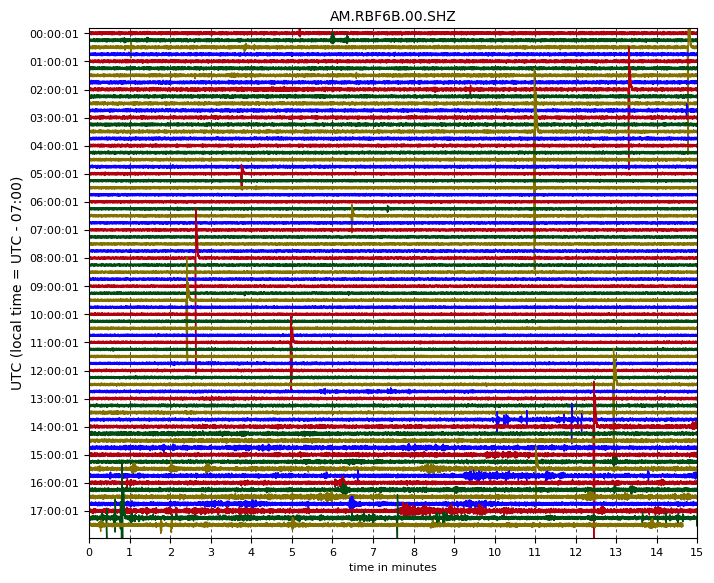

In [4]:
# Make a "dayplot"
st_rpi.plot(type='dayplot')

# Ignore the deprecation warning that pops up

So what can we see here? The spikes are the refrigerator compressor shaking the ground and the other signals are probably people walking nearby. There is definitely something starting about 17:07 UTC that is higher amplitude that most of the other signals. But, how do we know if this is actually the earthquake?

Since we know when the earthquake occurred (17:00 UTC) we can look for signal after the appropriate travel time. Using [this website](http://service.iris.edu/irisws/traveltime/docs/1/builder/) we can put in the event information, station location, and a few other parameters and get the travel times for different seimic phases. Here is the [link](http://service.iris.edu/irisws/traveltime/1/query?phases=p,P,S,PKP&evdepth=10.0&evloc=[51.812,-178.573]&staloc=[49.738,-123.101]) for this event.

Let's just focus on the P and S phases: the P waves should arrive at Quest in 6.77 minutes and the S waves to follow at about 12 minutes. In the above plot, we can definitely see the P-wave arrival at 17:00.78+6.77, or 17:07.55 minutes and maybe the S-wave arrival at 17:00.78+12.24 = 17:13.02 minutes.

Now that we know we can see something promising in the data, let's take a closer look by plotting only the time window we are interested in.

/home/nicole/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


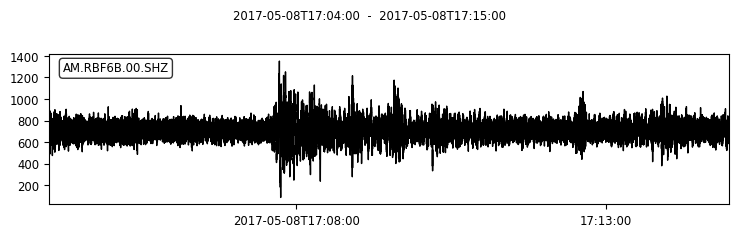

In [5]:
# Import the module to convert times into a UTC datetime object
from obspy.core import UTCDateTime

# Set the time window that we want to plot
start_t=UTCDateTime("2017-05-08T17:04:00")
end_t=UTCDateTime("2017-05-08T17:15:00")

# Plot the data
tr_rpi.plot(starttime=start_t, endtime=end_t)


There's the earthquake, right before 17:08. The ObsPy plot() method is good for previewing the data, especially if we have a large number of station and components. However, we would like to be able to add some additional things to our plots, like the P- and S-wave arrival times, change the limits on the axes, etc. Using the data and the other parameters from the Trace object, we can make nice plots with matplotlib.

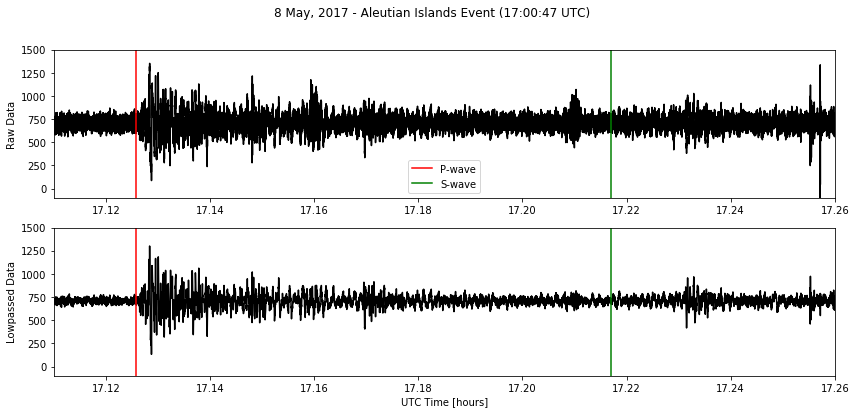

In [6]:
# Set the figure size
rcParams['figure.figsize'] = 14, 6

# (from the ObsPy tutorial: http://docs.obspy.org/tutorial/code_snippets/filtering_seismograms.html)

# Filtering with a lowpass on a copy of the original Trace
tr_filt = tr_rpi.copy()
tr_filt.filter('lowpass', freq=5.0, corners=2, zerophase=True)

# Now let's plot the raw and filtered data

# Generate the time vector, using the number of points (npts) and the sampling rate (50 Hz for the Shake)
# (these parameters are in the Trace.stats() method)
t = np.arange(0, tr_rpi.stats.npts / tr_rpi.stats.sampling_rate, tr_rpi.stats.delta)

# Plotting with axes set manually for the desired time window and the x-axis converted to hours
plt.subplot(211)
plt.plot(t/3600, tr_rpi.data, 'k')
plt.ylabel('Raw Data')
plt.axis((17.11,17.26,-100,1500))
plt.axvline(x=17.1258, color='r', label='P-wave')
plt.axvline(x=17.217, color='g',label='S-wave')
plt.legend(loc='lower center')

plt.subplot(212)
plt.plot(t/3600, tr_filt.data, 'k')
plt.axis((17.11,17.26,-100,1500))
plt.axvline(x=17.1258, color='r', label='P-wave')
plt.axvline(x=17.217, color='g',label='S-wave')
plt.ylabel('Lowpassed Data')
plt.xlabel('UTC Time [hours]')
plt.suptitle('8 May, 2017 - Aleutian Islands Event (17:00:47 UTC)')


With the higher frequencies filtered out, the arrival of the P waves is even easier to see. I don't really see the S-wave arrival but I think there are some other phases arriving at about 17.23 UTC.